# Bigram LM 

Implement Bigram LM for the tiny shakespeare dataset in Pytorch

## Read the dataset

In [1]:
with open("./data/tiny-shakespeare/input.txt") as file:
    data = file.read()

len(data)

1115394

In [4]:
data[:1000]

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

In [5]:
chars = sorted(list(set(data)))
chars

['\n',
 ' ',
 '!',
 '$',
 '&',
 "'",
 ',',
 '-',
 '.',
 '3',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [6]:
len(chars)

65

In [7]:
stoi = {c:i for i, c in enumerate(chars)}
itos = {i:c for i, c in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: "".join([itos[i] for i in l])

In [8]:
encoded_word = encode('hello world')
decoded_word = decode(encoded_word)
print(encoded_word)
print(decoded_word)

[46, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42]
hello world


## Create the model

Do it in a Pytorch-y way with torch nn modules

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1337)

In [50]:
class BigramLM(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_emb_table = nn.Embedding(vocab_size, vocab_size)
        print(f"Number of params: {sum(p.numel() for p in self.parameters())}")

    def forward(self, idx, targets=None):
        logits = self.token_emb_table(idx) # logits shape: [B, T ,C]
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))

        return logits, loss
    
    def generate(self, block_size, device, max_tokens=1000):
        curr_context, curr_str = [0], "\n"

        for _ in range(max_tokens):
            inp_context = torch.LongTensor(curr_context[-block_size:]).view(1, -1) # [B=1, T]
            inp_context = inp_context.to(device)
            logits, _ = self(inp_context) # [B, T, C]
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            probs = torch.softmax(logits, dim=1)
            # print(inp_context.shape, logits.shape, probs.shape)
            next_char_idx = torch.multinomial(probs, num_samples=1, replacement=True)[-1].item()
            curr_str += itos[next_char_idx]
            curr_context.append(next_char_idx)

        return curr_str

## Create helper functions for batch, train and loss computation

In [37]:
def get_batch(tokens, block_size, batch_size):
    batch = torch.randint(0, len(tokens)-block_size, (batch_size,)) # B dimension array of random indices
    Xb = torch.stack([torch.LongTensor(tokens[i:i+block_size]) for i in batch], dim=0) # Create (B, T) dimension array
    yb = torch.stack([torch.LongTensor(tokens[i+1:i+block_size+1]) for i in batch], dim=0) # Create (B, T) dimension array
    return Xb, yb

In [38]:
@torch.no_grad()
def compute_loss(tokens, block_size, batch_size, model, device):
    loss_values = []
    for _ in range(1000):
        Xb, yb = get_batch(tokens, block_size, batch_size)
        Xb, yb = Xb.to(device), yb.to(device)

        _, loss = model(Xb, yb)
        loss_values.append(loss.item())

    mean_loss = torch.FloatTensor(loss_values).mean().item()
    return mean_loss

In [54]:
def train(train_tokens, val_tokens, model, optimizer, device, block_size, batch_size, n_iters, eval_interval):
    stepi, train_lossi, val_lossi = [], [], []
    
    for i in range(n_iters):
        model.train()
        Xb, yb = get_batch(train_tokens, block_size, batch_size)
        Xb, yb = Xb.to(device), yb.to(device)

        # forward
        _, loss = model(Xb, yb)

        # set grads to zero
        optimizer.zero_grad(set_to_none=True)

        # do backward
        loss.backward()

        # optimizer step
        optimizer.step()

        if i % eval_interval == 0:
            model.eval()
            train_loss = compute_loss(train_tokens, block_size, batch_size, model, device)
            val_loss = compute_loss(val_tokens, block_size, batch_size, model, device)

            stepi.append(i//eval_interval)
            train_lossi.append(train_loss)
            val_lossi.append(val_loss)

            print(f"Step {i}/{n_iters} --> Train: {train_loss:.4f} | Val: {val_loss:.4f}")

        # break

    return stepi, train_lossi, val_lossi

## Decide the hyperparams

In [40]:
vocab_size = len(stoi)
batch_size = 32
block_size = 8
n_iters = 20000
eval_interval = n_iters//20
lr = 1e-3
device = ('cuda' if torch.cuda.is_available()
          else 'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available()
          else 'cpu')

## 1. Create dataset and create splits

In [41]:
tokens = encode(data)
len(tokens)

1115394

In [42]:
data_size = len(tokens)
split_idx = int(0.8 * data_size)
train_tokens = tokens[:split_idx]
val_tokens = tokens[split_idx:]
len(train_tokens), len(val_tokens)

(892315, 223079)

## 2. Create the model, optimizer

In [65]:
bigram_lm = BigramLM(vocab_size)
bigram_lm = bigram_lm.to(device)

Number of params: 4225


In [66]:
optimizer = optim.AdamW(bigram_lm.parameters(), lr=lr)

### Generate from untrained model

In [67]:
from IPython.display import display, Markdown
display(Markdown(bigram_lm.generate(block_size, device)))


lZL$CkgOd Lw&xRd.jZno'RgjnL-XBYQm&LS
fQ3xcunQ;gtL
,HnRbfn!Kqjig d?ofnQHT'y;EmkcwlataWNjqXX'oYsjqVnQgjUMl&$KTO,x-b$gMzyuDYGGbuPsQeZ! TaX'NAjsh$:eKqqtIZka t$a$!Vbv&:q!VcWxnx$wgga:kRgtwWPMsqlR?:pdxE'oahsQlJgUAiNApmrYwkQJAve?!z XIcyDsUcKVB&LjfoZ,XBWUAGXSrOJQeYheJ&'Pv.:p:TsIBZPzyzXHmHNEUrk,IXyyWIh cfzD,!VoGc&L-!;NFrvnQf&$JtUcPLEiNoLQjfB!yuBhBENQ&uRWPMxjDtLNu$gKYiNAxE&W!RF:M$weKpXrOw3qggKjLvFxYsYygRFiDVVQLH? cQE,XqjdsJshpX,,k.JpdG e3izAnP:hd'AfB-L,'opICENRwe!k;wipfB-$qZH-? hECM.&DDr3f;UxEc$' KPjijLofsPM-sYnxIkWopXhVQ3?AjpX,IkAr,NAinzpUd.3rxE&Os' Y?OHcZbKjAt.wUtrsP EayCn? cFmAqzpgjojEjO.RE,xMs'iTmmh3:,dCnjs&'cDn?&':KtURQHzsoqjRrsPHAfKp&B-$AjiNNd.JAO;cpdMa;dyKnjXReNdcLtaPjfkb3Nog!sQmdAfFENRgbHlOx-!&l&LHJ;ZQJvi?ldG'yRxmtqHiOH&Y3ymQ3yZggOd3wEAv;B-.Xgj$LQJFRBRrRH&zzCspXH
j?3B.l?jYI
 x
jRK?TmThAvJkSzcHzy.WE'qjAXllmPkQX,twZZLHMHlDdwCIBhFE'IhzyWpX,Y?oaQ3ARaXygbO!$uecRXQXjEzVM;Is.wed3lweny&z
OiedWUcwieJ;VMqllaqXE.BH:oIPgkhep,?;Eda
gxLvv.zrThzckxINhd.IsqLHMo;qFY
Z;j
lQF'
!OtlgJv&!:gtqp3TxkJV&a;'cukyZC

## 3. Train the model

In [68]:
stepi, train_lossi, val_lossi = train(train_tokens, val_tokens,\
       bigram_lm, optimizer, device, block_size, batch_size, n_iters, eval_interval)

Step 0/20000 --> Train: 4.5724 | Val: 4.5826
Step 1000/20000 --> Train: 3.6310 | Val: 3.6446
Step 2000/20000 --> Train: 3.0805 | Val: 3.1036
Step 3000/20000 --> Train: 2.7848 | Val: 2.8101
Step 4000/20000 --> Train: 2.6314 | Val: 2.6676
Step 5000/20000 --> Train: 2.5582 | Val: 2.5908
Step 6000/20000 --> Train: 2.5105 | Val: 2.5480
Step 7000/20000 --> Train: 2.4936 | Val: 2.5287
Step 8000/20000 --> Train: 2.4740 | Val: 2.5182
Step 9000/20000 --> Train: 2.4703 | Val: 2.5101
Step 10000/20000 --> Train: 2.4626 | Val: 2.5042
Step 11000/20000 --> Train: 2.4598 | Val: 2.5051
Step 12000/20000 --> Train: 2.4559 | Val: 2.5001
Step 13000/20000 --> Train: 2.4527 | Val: 2.5010
Step 14000/20000 --> Train: 2.4533 | Val: 2.5005
Step 15000/20000 --> Train: 2.4518 | Val: 2.4972
Step 16000/20000 --> Train: 2.4479 | Val: 2.5022
Step 17000/20000 --> Train: 2.4536 | Val: 2.5004
Step 18000/20000 --> Train: 2.4530 | Val: 2.5041
Step 19000/20000 --> Train: 2.4504 | Val: 2.5045


In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

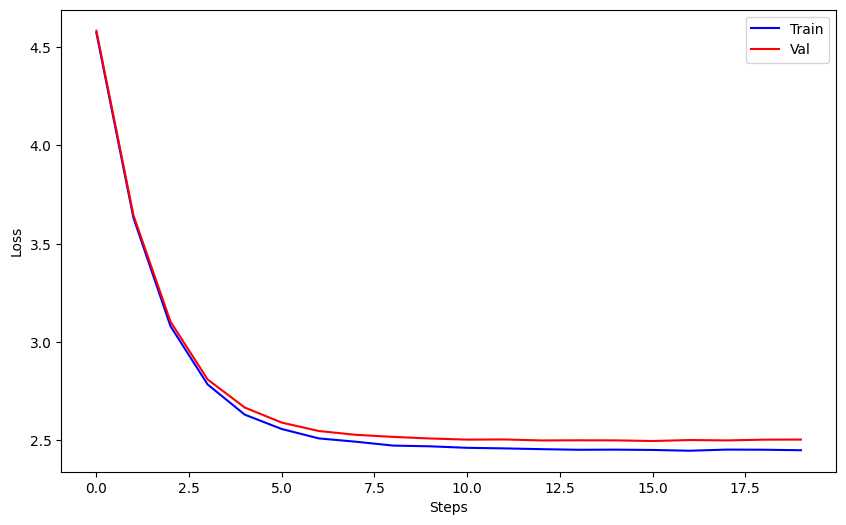

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(stepi, train_lossi, label='Train', color='blue')
plt.plot(stepi, val_lossi, label='Val', color='red')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Generate from trained model

In [71]:
display(Markdown(bigram_lm.generate(block_size, device)))



o R:
' Clf BULI INUSucin mintin
Th,
JUSeprf fr oulky fldo lort crass thei I pr th he mea ungithe f--MEDYomoucrje;

Po hatand cowou;
OUCome the cowis? thee it of.
TMBEvestote h
TEE:
Malffod the fatono fowine s ris

IORD:
Rid s! sthre glino owiswea foimolfutorouly s thir,
NDore.
Afrst: ter than s
Whtinouthemay hith lly purth, he ano fournse, h'd GAnenthaningh Mou ndak;
G l wand: h tho mpeerad t ce on thair! meirat

Thie bl, n sthed.
LA owakiour de knd qupradoone gayouss AMANToo polave,

Bur planile t'ed cove azevolano owis mend CK:
LARWe s totey whers. and? sexfe hehaven is tyofinot clur'


'c. d atrs;
Athinrvind the.
Fide ththende, onoulin frke ilyouatens, wod spoulorstin.
Whenthaishe:
WAnsep, m hady bren, bomaran dect t lld p wat ind ccik ce.
YCA: t ain milat by----S:
G dasthorlar o thermyolfome, grath yse seic!
Ththagea ancope inthotho d wainkitean keneay te-pll hat ind bon s at, ming hisool.

iff heerotheau avelfiorelilofondomir bed?
Thoure as o pe bur abr.
PURYou thee o wnouseat ng